In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
X = pd.read_csv("data/dataMungingSave.csv", index_col=0)
X.head()

,COUNTRY,YEAR,NY.GDP.MKTP.CD_0,NY.GDP.PCAP.CD_0,AG.PRD.CREL.MT_0,AG.YLD.CREL.KG_0,AG.PRD.CROP.XD_0,AG.PRD.FOOD.XD_0,AG.LND.CREL.HA_0,AG.PRD.LVSK.XD_0,...,SP.DYN.TFRT.IN_4,TX.VAL.MRCH.CD.WT_4,TX.VAL.MRCH.WL.CD_4,TX.VAL.MRCH.RS.ZS_4,TX.VAL.MRCH.HI.ZS_4,TM.VAL.MRCH.CD.WT_4,TM.VAL.MRCH.WL.CD_4,TM.VAL.MRCH.RS.ZS_4,TM.VAL.MRCH.HI.ZS_4,TG.VAL.TOTL.GD.ZS_4
0,AFG,1971,1.673333e+09,161.384702,3826000.0,1224.516,83.05,70.20,3124500.0,60.38,...,7.450,100000000.0,99900000.0,47.314314,42.712713,141000000.0,145386000.0,32.425405,57.253106,13.161423
1,AFG,1977,1.733333e+09,144.173944,4270000.0,1279.592,91.25,73.56,3337000.0,58.45,...,7.449,306000000.0,313137000.0,45.115397,35.590492,328000000.0,458652000.0,45.553055,45.343964,21.467268
2,AFG,1978,2.155555e+09,175.027098,4351000.0,1301.915,94.92,76.02,3342000.0,61.00,...,7.449,321000000.0,269156000.0,43.718141,27.069432,395000000.0,450516000.0,53.467801,34.542835,21.696969
3,AFG,1979,2.366667e+09,188.085136,4481000.0,1316.392,97.68,78.24,3404000.0,63.38,...,7.449,474000000.0,435015000.0,60.016551,18.152248,425000000.0,551216000.0,68.909647,24.561515,24.310830
4,AFG,1980,2.555556e+09,199.164809,4624000.0,1362.404,102.93,83.72,3394000.0,69.07,...,7.449,670000000.0,670474000.0,64.592065,19.471896,841000000.0,494754000.0,60.669343,32.162044,41.491344


In [6]:
predictionFeature = 'SP.ADO.TFRT'
columns=['CountryCode', 'IndicatorCode', 'Year', 'Value']
data = pd.read_csv("data/indicators.csv", usecols=(columns))
pData = data[data.IndicatorCode == predictionFeature]
yearsForward = 5

# TODO optimize later
futureValues = [pData[(pData.CountryCode == row[0]) & (pData.Year == int(row[1]) + yearsForward)].Value.values for row in X.values]
currentValues = [pData[(pData.CountryCode == row[0]) & (pData.Year == int(row[1]))].Value.values for row in X.values]
rowsWithPredictions = [(len(futureValues[i]) == 1 & len(currentValues[i]) == 1) for i in range(len(futureValues))]
values = [[futureValues[i][0] - currentValues[i][0], futureValues[i][0], currentValues[i][0]] for i in range(len(futureValues)) if (len(futureValues[i]) == 1 & len(currentValues[i]) == 1)]
X = X[rowsWithPredictions]
y = pd.DataFrame(values, columns=['Change', 'FutureValue', 'CurrentValue'])
print (len(X))
print (len(y))
y.head()

5147
5147


,Change,FutureValue,CurrentValue
0,3.5760,148.8970,145.3210
1,5.4360,155.2270,149.7910
2,5.4976,156.3758,150.8782
3,5.5592,157.5246,151.9654
4,5.6208,158.6734,153.0526


In [7]:
from sklearn.cross_validation import train_test_split
X_data = X.drop(['COUNTRY', 'YEAR'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y.Change, test_size=0.2, random_state=0)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
import seaborn as sb
import matplotlib.pyplot as plt
def getGraphData(clf, country, displayRelativeValues):
    indices = (X.COUNTRY == country)
    realValues = y[indices].values
    plotData = X[indices]
    
    dataPoints = []
    plotDataValues = plotData.drop(['COUNTRY', 'YEAR'], axis=1).values
    plotDataScaledValues = scaler.transform(plotDataValues)
    predictions = clf.predict(plotDataScaledValues)
    for i in range(len(plotData.YEAR)):
        relativePortion = 0 if displayRelativeValues else realValues[i][2] 
        dataPoints.append([country + "_PREDICTED", plotData.YEAR.values[i] + yearsForward, predictions[i] + relativePortion, True])
        dataPoints.append([country + "_REAL", plotData.YEAR.values[i] + yearsForward, realValues[i][0] + relativePortion, False])
    return len(plotData.YEAR), dataPoints

In [10]:
def testClfWithCountries(clf, countries, displayRelativeValues):
    countryGraphData = []
    for country in countries:
        numYears, dataPoints = getGraphData(clf, country, displayRelativeValues)
        countryGraphData.append(dataPoints)
    
    countryGraphDataFlattened = [item for sublist in countryGraphData for item in sublist]
    
    graphData = pd.DataFrame(countryGraphDataFlattened, columns=['COUNTRY', 'YEAR', 'VALUE', 'IS_PREDICTED'])
    
    numYears = len(countries)
    
    linestyles = ["--", "-"]*numYears
    markers= ["x", "o"]*numYears
    palette = np.repeat(sb.color_palette("Set1", n_colors=numYears, desat=.5), 2, axis=0)

    fig, (ax) = plt.subplots(1,1, figsize=(20,7))
    graph = sb.pointplot(x='YEAR', y='VALUE', hue='COUNTRY', linestyles=linestyles, markers=markers, palette=palette, data=graphData, ax=ax)

In [11]:
import random
def testClf(clf, numCountries=5, displayRelativeValues=False, samples=len(y_train)):
    countries = ['AFG', 'ALB', 'DZA', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS', 'AUT',
           'AZE', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BOL', 'BIH',
           'BRA', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN',
           'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COG', 'CRI', 'CIV',
           'HRV', 'CUB', 'CYP', 'CZE', 'ZAR', 'DNK', 'DOM', 'EAP', 'ECU',
           'EGY', 'SLV', 'EST', 'ETH', 'ECA', 'FJI', 'FIN', 'FRA', 'GAB',
           'GEO', 'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY',
           'HTI', 'HIC', 'HND', 'HUN', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
           'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KOR', 'KWT',
           'KGZ', 'LAO', 'LAC', 'LVA', 'LBN', 'LBR', 'LBY', 'LTU', 'LMY',
           'LMC', 'LUX', 'MKD', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT',
           'MRT', 'MUS', 'MEX', 'MNA', 'MIC', 'MDA', 'MNG', 'MAR', 'MOZ',
           'NPL', 'NLD', 'NZL', 'NIC', 'NER', 'NGA', 'NOR', 'OMN', 'PAK',
           'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'POL', 'PRT', 'QAT', 'ROM',
           'RUS', 'RWA', 'STP', 'SAU', 'SEN', 'SLE', 'SVK', 'SVN', 'SLB',
           'ZAF', 'SAS', 'ESP', 'LKA', 'VCT', 'SSA', 'SDN', 'SUR', 'SWE',
           'CHE', 'SYR', 'TJK', 'TZA', 'THA', 'BHS', 'GMB', 'TGO', 'TTO',
           'TUN', 'TUR', 'TKM', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMC',
           'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'WLD', 'YEM', 'ZMB', 'ZWE']
    #random.shuffle(countries)
    clf.fit(X_train[:samples], y_train[:samples])
    testClfWithCountries(clf, countries[0:numCountries], displayRelativeValues)
    print (clf.score(X_test, y_test))

/Users/jgzuke/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.645339629639


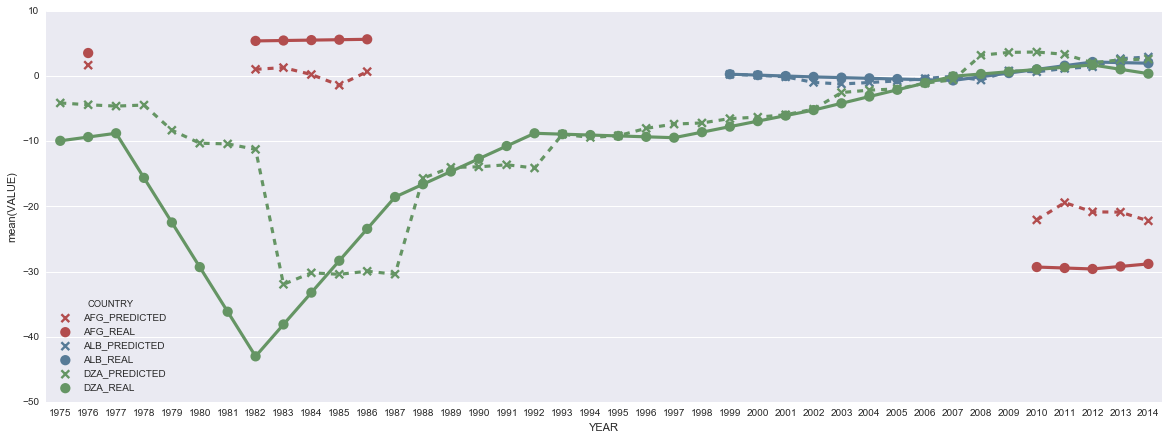

In [12]:
from sklearn.linear_model import LinearRegression
clf_lr = LinearRegression()
testClf(clf_lr, 3, True)

Epoch 1/30
4117/4117 [==============================] - 0s - loss: 40.2295     
Epoch 2/30
4117/4117 [==============================] - 0s - loss: 30.1967     
Epoch 3/30
4117/4117 [==============================] - 0s - loss: 27.0277     
Epoch 4/30
4117/4117 [==============================] - 0s - loss: 24.9159     
Epoch 5/30
4117/4117 [==============================] - 0s - loss: 23.0782     
Epoch 6/30
4117/4117 [==============================] - 0s - loss: 21.0196     
Epoch 7/30
4117/4117 [==============================] - 0s - loss: 20.0860     
Epoch 8/30
4117/4117 [==============================] - 0s - loss: 18.9782     
Epoch 9/30
4117/4117 [==============================] - 0s - loss: 17.8111     
Epoch 10/30
4117/4117 [==============================] - 0s - loss: 16.9477     
Epoch 11/30
4117/4117 [==============================] - 0s - loss: 16.3874     
Epoch 12/30
4117/4117 [==============================] - 0s - loss: 16.0103     
Epoch 13/30
4117/4117 [==============

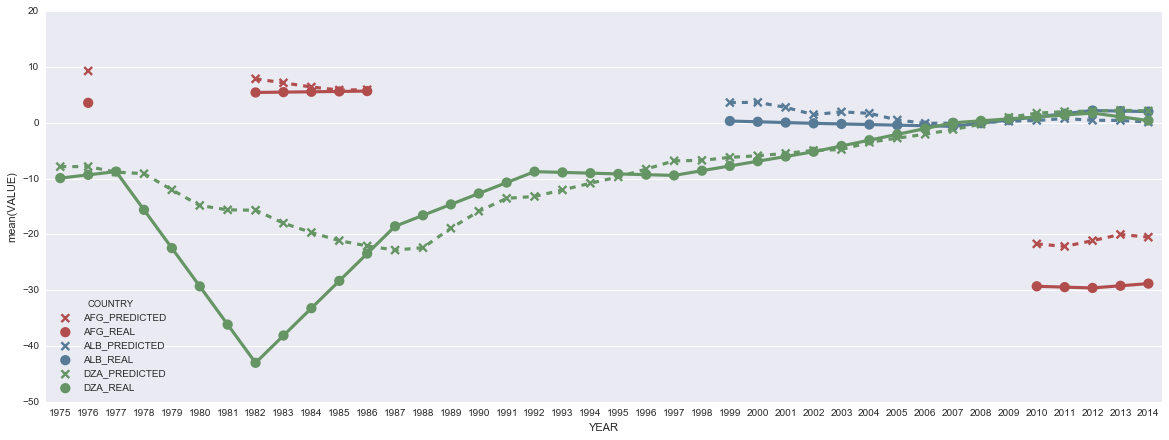

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
def baseline_model():
    model = Sequential([
        Dense(32, input_dim=315),
        Activation('relu'),
        Dense(1)
    ])
    
    #model = Sequential()
    #model.add(Dense(35, input_dim=315, init='normal', activation='relu'))
    #model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
clf_nn = KerasRegressor(build_fn=baseline_model, nb_epoch=10, batch_size=5)
testClf(clf_nn, 3, True)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.6s finished


0.906186247189


SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

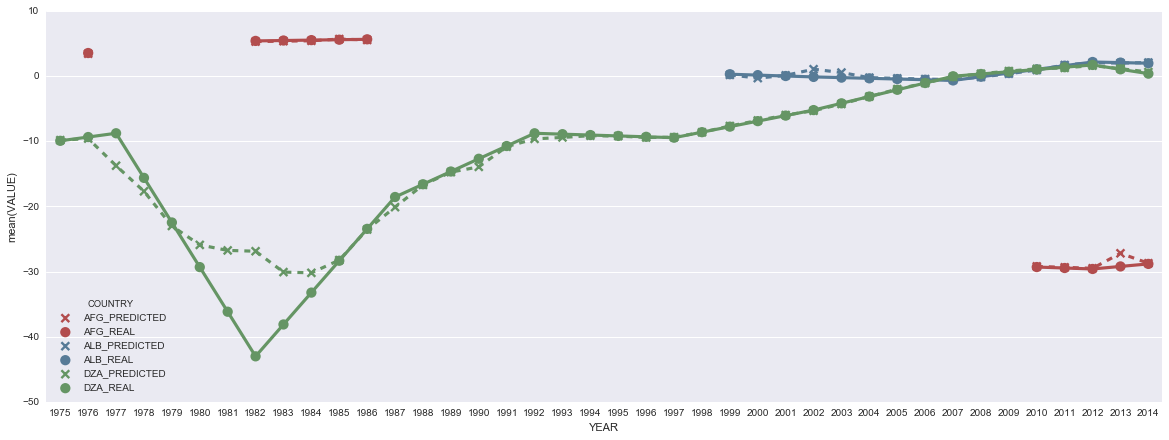

In [27]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
param_grid = [
    {'C': [40, 80], 'gamma': [0.05, 0.02], 'kernel': ['rbf']},
]
clf_svr = GridSearchCV(SVR(), param_grid, verbose=True, cv=2)
# clf_svr = SVR()
testClf(clf_svr, 3, True) #, samples=2000)
clf_svr.best_estimator_

In [248]:
import lasagne
import theano
import theano.tensor as T

In [249]:
X_train.shape

(4117, 315)

In [250]:
y_train.shape

(4117,)

In [258]:
input_var = T.tensor4('X')
target_var = T.ivector('y')

In [259]:
from lasagne.nonlinearities import leaky_rectify, softmax
network = lasagne.layers.InputLayer((None, 3, 32, 32), input_var)
network = lasagne.layers.Conv2DLayer(network, 64, (3, 3),
                                     nonlinearity=leaky_rectify)
network = lasagne.layers.Conv2DLayer(network, 32, (3, 3),
                                     nonlinearity=leaky_rectify)
network = lasagne.layers.Pool2DLayer(network, (3, 3), stride=2, mode='max')
network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, 0.5),
                                    128, nonlinearity=leaky_rectify,
                                    W=lasagne.init.Orthogonal())
network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, 0.5),
                                    10, nonlinearity=softmax)

In [260]:
# create loss function
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean() + 1e-4 * lasagne.regularization.regularize_network_params(
        network, lasagne.regularization.l2)

In [261]:
# create parameter update expressions
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01,
                                            momentum=0.9)


In [262]:
train_fn = theano.function([input_var, target_var], loss, updates=updates)


In [267]:
for epoch in range(100):
    loss = 0
    for i in range(len(y_train)):
        loss += train_fn(X_train[i], y_train[i])
    print("Epoch %d: Loss %g" % (epoch + 1, loss / len(y_train)))

TypeError: ('Bad input argument to theano function with name "<ipython-input-262-a9a5249efc94>:1"  at index 0(0-based)', 'Wrong number of dimensions: expected 4, got 1 with shape (315,).')

In [24]:
len(y_train)

4117